In [1]:
from rdkit import Chem
import psycopg2
import pandas as pd
import psycopg2
hostname = 'scotland'
dbname = 'cs_mdfps'
username = 'cschiebroek'
import warnings
# Suppress the FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)
from rdkit.Chem import Descriptors
from rdkit.Chem.Descriptors import CalcMolDescriptors
import sys
sys.path.append('../..')
from carl import utils_carl
from carl.utils_carl import train_pred_xgboost_2d, getStatValues,density_plot, get_mdfps
from functools import reduce

In [2]:

# cn = psycopg2.connect(host=hostname, dbname=dbname, user=username)
# cur = cn.cursor()

# # Define the SQL query to perform the joins with schema qualification
# sql_query = '''
# SELECT cs_mdfps_schema.confid_data.conf_id AS confid,
#        public.conformers.molblock,
#        cs_mdfps_schema.experimental_data.vp_log10Pa
# FROM cs_mdfps_schema.confid_data
# INNER JOIN public.conformers
# ON cs_mdfps_schema.confid_data.conf_id = public.conformers.conf_id
# INNER JOIN cs_mdfps_schema.experimental_data
# ON public.conformers.molregno = cs_mdfps_schema.experimental_data.molregno
# WHERE cs_mdfps_schema.confid_data.confgen_uuid = '906589dd-76fa-4d7b-aa9f-1ee90abe3835';

# '''
# # Execute the SQL query
# cur.execute(sql_query)
# results = cur.fetchall()
# #print columns with index
# print('Columns:')
# for col in cur.description:
#     print(col)
# molblocks = [r[1] for r in results]
# mols = [Chem.MolFromMolBlock(m) for m in molblocks]
# mols = [Chem.AddHs(m) for m in mols]
# MolDescriptors_vectors = [list(CalcMolDescriptors(m).values()) for m in mols]


In [2]:
import sys
sys.path.append('../..')
from carl import utils_carl
from carl.utils_carl import train_pred_xgboost_2d, getStatValues,density_plot, get_mdfps
from functools import reduce

In [4]:
# #make dataframe of the moldescriptors
# df = pd.DataFrame(MolDescriptors_vectors)
# df.columns = list(CalcMolDescriptors(mols[0]).keys())
# df['vp'] = [r[2] for r in results]
# df['confid'] = [r[0] for r in results]
# df = df.set_index('confid')
# df = df.reset_index()

In [3]:
df = pd.read_csv('mdfp_and_rdkit_features_all_mols.csv')

In [4]:
params = {
    # Parameters that we are going to tune.
    'max_depth':3,
    'min_child_weight': 6,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    "objective" : 'reg:squarederror',
}
#load X features: carl/RDKit_2D_descriptors.pkl
RDKit_feature_names = pd.read_pickle('/localhome/cschiebroek/MDFPs/mdfptools/carl/data/outputs/RDKit_2D_descriptors.pkl')
output_2d_only = train_pred_xgboost_2d(df,params=params,X_features=RDKit_feature_names,y_label='vp')
real_2d_only, prediction_2d_only = (reduce(lambda a,b : list(a)+list(b) , output_2d_only[0]), reduce(lambda a,b : list(a)+list(b), output_2d_only[1]))
mdfp_features_no_2d = ['water_intra_crf_mean', 'water_intra_crf_std', 'water_intra_crf_median', 'water_intra_lj_mean', 'water_intra_lj_std', 'water_intra_lj_median', 'water_total_crf_mean', 'water_total_crf_std', 'water_total_crf_median', 'water_total_lj_mean', 'water_total_lj_std', 'water_total_lj_median', 'water_intra_ene_mean', 'water_intra_ene_std', 'water_intra_ene_median', 'water_total_ene_mean', 'water_total_ene_std', 'water_total_ene_median', 'water_rgyr_mean', 'water_rgyr_std', 'water_rgyr_median', 'water_sasa_mean', 'water_sasa_std', 'water_sasa_median']
output_combined = train_pred_xgboost_2d(df,params=params,X_features=RDKit_feature_names+mdfp_features_no_2d,y_label='vp')
real_combined, prediction_combined = (reduce(lambda a,b : list(a)+list(b) , output_combined[0]), reduce(lambda a,b : list(a)+list(b), output_combined[1]))

Plot 1 Stats:
RMSE:  1.2240529735051782
MAE:  0.7530258437360301
R2:  0.8852345251786184
Plot 2 Stats:
RMSE:  1.2590723965498132
MAE:  0.7740378662771044
R2:  0.8786242264492747


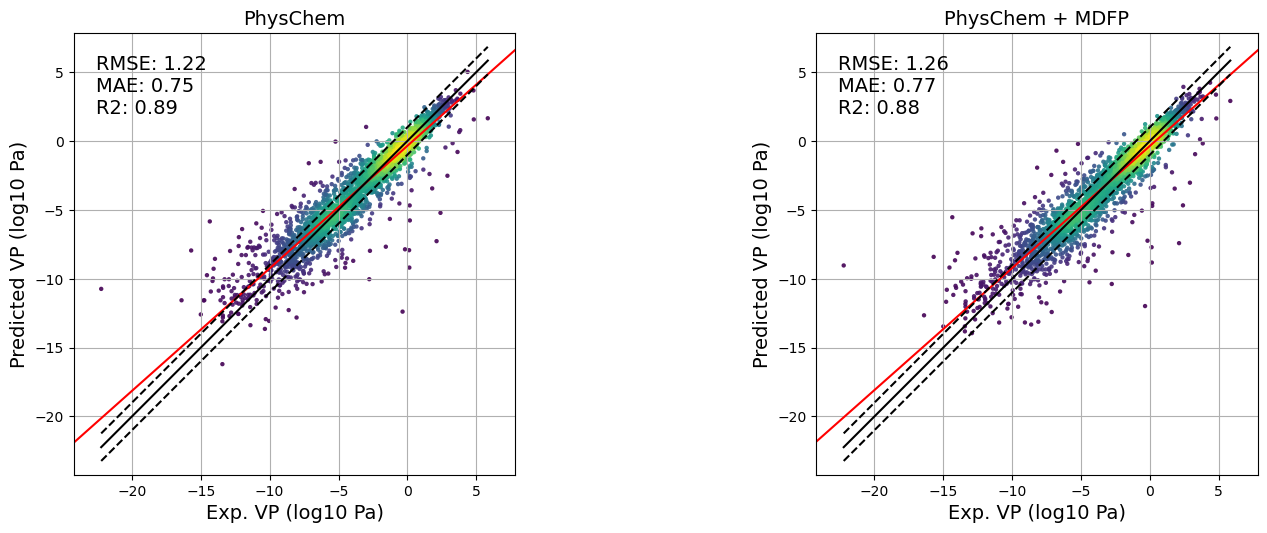

In [5]:
from carl.utils_carl import density_plot_multiple
density_plot_multiple(reals = [real_2d_only,real_combined],predictions=[prediction_2d_only,prediction_combined],titles = ['PhysChem','PhysChem + MDFP'])

In [6]:
#okay, now I actually want to look at prediction error of only 2d vs only mdfp per mol, and look at the difference
params = { #hyperparameters optimized by ShuZe Wang
    'max_depth':5,
    'min_child_weight': 5,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
}
import numpy as np
from sklearn.model_selection import GroupKFold, KFold
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
gkf = GroupKFold(n_splits=5)

# Create an empty list to store the indices of each fold
fold_indices = []
# Group the data by 'molregno'
groups = df['molregno']

# Iterate over each fold
for train_idx, test_idx in gkf.split(df, groups=groups):
    fold_indices.append((train_idx, test_idx))
mdfp_features_all = ['NumHeavyAtoms', 'NumRotatableBonds', 'NumN', 'NumO', 'NumF', 'NumP', 'NumS', 'NumCl', 'NumBr', 'NumI', 'water_intra_crf_mean', 'water_intra_crf_std', 'water_intra_crf_median', 'water_intra_lj_mean', 'water_intra_lj_std', 'water_intra_lj_median', 'water_total_crf_mean', 'water_total_crf_std', 'water_total_crf_median', 'water_total_lj_mean', 'water_total_lj_std', 'water_total_lj_median', 'water_intra_ene_mean', 'water_intra_ene_std', 'water_intra_ene_median', 'water_total_ene_mean', 'water_total_ene_std', 'water_total_ene_median', 'water_rgyr_mean', 'water_rgyr_std', 'water_rgyr_median', 'water_sasa_mean', 'water_sasa_std', 'water_sasa_median']

y = df['vp']  
params = params
output = ([],[],[],[],[])
selection_2d_features = RDKit_feature_names

X_mdfp = df[mdfp_features_all]
X_mdfp = StandardScaler().fit_transform(X_mdfp)
X_2d = df[selection_2d_features]
X_2d = StandardScaler().fit_transform(X_2d)
y = df['vp']
# Iterate over each fold
for fold, (train_idx, test_idx) in enumerate(fold_indices):

    #get the train and test data
    X_train_mdfp = X_mdfp[train_idx]
    X_test_mdfp = X_mdfp[test_idx]
    X_train_2d = X_2d[train_idx]
    X_test_2d = X_2d[test_idx]
    y_train = y[train_idx]
    y_test = y[test_idx]



    # Create DMatrix for training and testing
    dtrain_mdfp = xgb.DMatrix(X_train_mdfp, label=y_train)
    dtest_mdfp = xgb.DMatrix(X_test_mdfp, label=y_test)

    dtrain_2d = xgb.DMatrix(X_train_2d, label=y_train)
    dtest_2d = xgb.DMatrix(X_test_2d, label=y_test)


    model_mdfp = xgb.train(
        params,
        dtrain_mdfp,
        num_boost_round=999,
        evals=[(dtest_mdfp, "Test")],
        early_stopping_rounds=10,
        verbose_eval=False

    )

    model_2d = xgb.train(
        params,
        dtrain_2d,
        num_boost_round=999,
        evals=[(dtest_2d, "Test")],
        early_stopping_rounds=10,
        verbose_eval=False

    )
    pp_mdfp = model_mdfp.predict(dtest_mdfp)
    pp_2d = model_2d.predict(dtest_2d)

    output[0].append(y_test)
    output[1].append(pp_mdfp)
    molregnos_test = df['molregno'].iloc[test_idx]
    confids_test = df['confid'].iloc[test_idx]
    
    output[2].append(molregnos_test)
    output[3].append(confids_test)
    output[4].append(pp_2d)

    rmse_mdfp = np.sqrt(mean_squared_error(y_test, pp_mdfp, squared=False))
    rmse_2d = np.sqrt(mean_squared_error(y_test, pp_2d, squared=False))
    print(f"Fold {fold + 1}: MDFP RMSE = {rmse_mdfp}, 2D RMSE = {rmse_2d}")



Fold 1: MDFP RMSE = 1.2120086081380206, 2D RMSE = 1.1691916997618543
Fold 2: MDFP RMSE = 1.1813995099300418, 2D RMSE = 1.1095116060746109
Fold 3: MDFP RMSE = 1.1496915511718304, 2D RMSE = 1.067365484561534
Fold 4: MDFP RMSE = 1.2512689517410922, 2D RMSE = 1.1447116971549225
Fold 5: MDFP RMSE = 1.1284805903962247, 2D RMSE = 1.0228052596196315


In [7]:
#average over conformers
vps = reduce(lambda a,b : list(a)+list(b) , output[0])
preds_mdfp = reduce(lambda a,b : list(a)+list(b), output[1])
molregnos = reduce(lambda a,b : list(a)+list(b), output[2])
confids = reduce(lambda a,b : list(a)+list(b), output[3])
preds_2d = reduce(lambda a,b : list(a)+list(b), output[4])

df_preds = pd.DataFrame({'vp': vps, 'pred_mdfp': preds_mdfp, 'pred_2d': preds_2d, 'confid': confids, 'molregno': molregnos})
df_preds = df_preds.groupby('molregno').mean()
#drop confid
df_preds = df_preds.drop(columns=['confid'])
#get abs error for both preds
df_preds['abs_error_mdfp'] = abs(df_preds['vp'] - df_preds['pred_mdfp'])
df_preds['abs_error_2d'] = abs(df_preds['vp'] - df_preds['pred_2d'])
df_preds

,vp,pred_mdfp,pred_2d,abs_error_mdfp,abs_error_2d
molregno,,,,,
1,1.100855,1.561785,0.843428,0.460930,0.257427
6,-14.744727,-11.033422,-8.154742,3.711305,6.589985
7,-0.301067,-0.427523,0.269263,0.126456,0.570330
8,-6.053323,-6.347808,-6.229554,0.294486,0.176231
9,0.591625,0.559341,1.270787,0.032284,0.679163
...,...,...,...,...,...
4240,-7.301899,-6.990613,-6.888975,0.311286,0.412924
4241,-8.356584,-7.680636,-7.623059,0.675948,0.733525
4242,-6.770000,-6.363488,-6.761322,0.406512,0.008678


Plot 1 Stats:
RMSE:  1.409016617528164
MAE:  0.8751584984820857
R2:  0.8479816863508847
Plot 2 Stats:
RMSE:  1.2242682386440848
MAE:  0.7290184684561803
R2:  0.8852272352494398


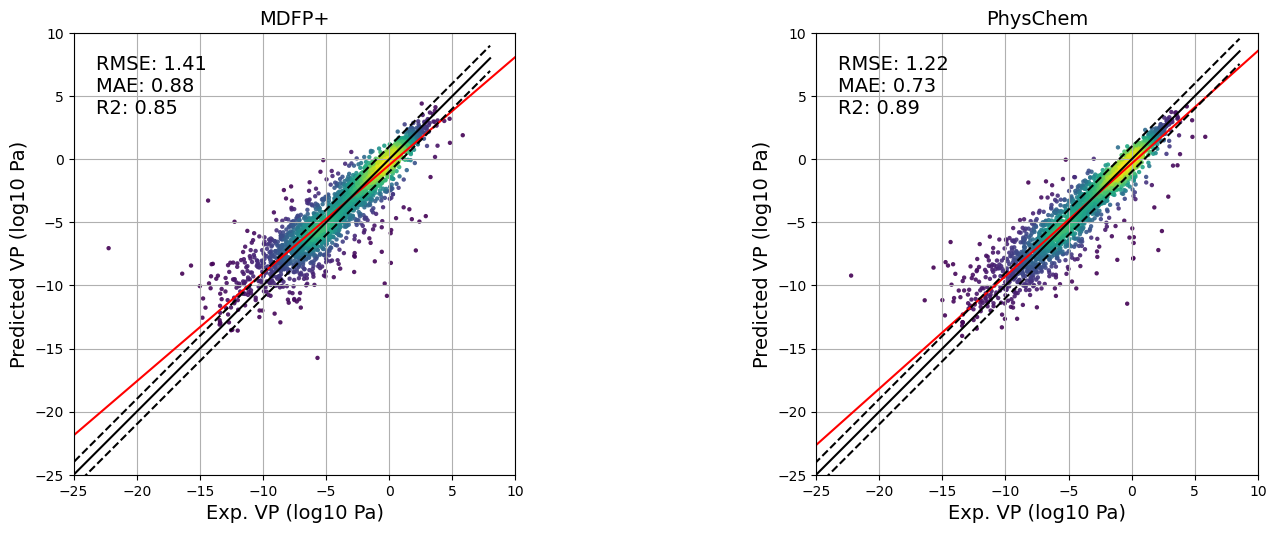

In [8]:
#plot these two
density_plot_multiple(reals = [df_preds['vp'],df_preds['vp']],predictions=[df_preds['pred_mdfp'],df_preds['pred_2d']],titles = ['MDFP+','PhysChem'],bounds=[-25,10])

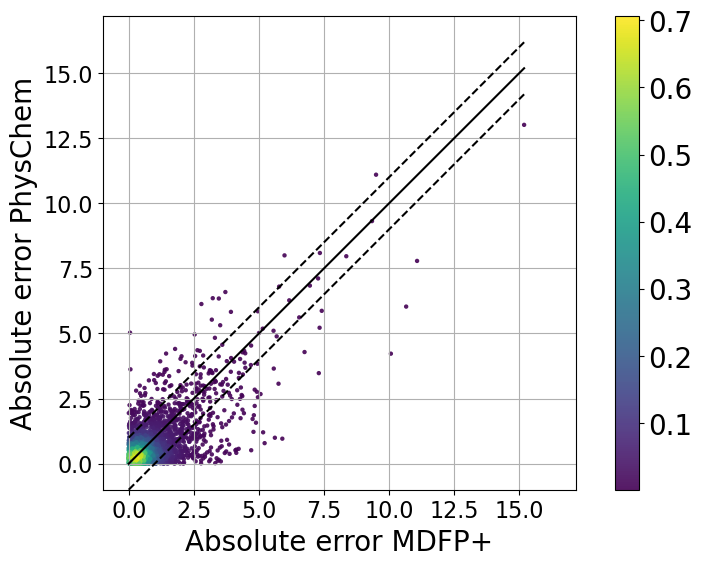

In [9]:
import matplotlib.pyplot as plt

fsize = 20
real = df_preds['abs_error_mdfp'].tolist()
prediction = df_preds['abs_error_2d'].tolist()
fig = plt.figure(1, figsize=(10, 6.15))
ax = plt.subplot(111)
lower = -1
upper = max(prediction + real) + 2
x = np.linspace(lower, upper,len(real))
plt.plot([min(prediction + real), max(prediction + real)], [min(prediction + real), max(prediction + real)], 'k-')
plt.plot([min(prediction + real), max(prediction + real)], [min(prediction + real)-1, max(prediction + real) - 1], 'k--')
plt.plot([min(prediction + real), max(prediction + real)], [min(prediction + real)+1, max(prediction + real)+1], 'k--')

import statsmodels.api as sm
dens_u = sm.nonparametric.KDEMultivariate(data=[real, prediction],var_type='cc', bw='normal_reference')
z = dens_u.pdf([real, prediction])

sc = plt.scatter(real, prediction, lw=0, c=z, s=10, alpha = 0.9)

cbar = plt.colorbar(sc)
cbar.ax.tick_params(labelsize=fsize)

plt.xlabel(r'Absolute error MDFP+', fontsize=fsize)
plt.ylabel(r'Absolute error PhysChem', fontsize=fsize)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
plt.grid(1,"both")
plt.axis([lower, upper, lower, upper])
#make square
ax.set_aspect('equal', 'box')
plt.show()

In [12]:
#get df for points were mdfp is better then 2d
df_mdfp_better = df_preds[df_preds['abs_error_mdfp'] < df_preds['abs_error_2d']]
print(len(df_mdfp_better))
df_mdfp_better
molregnos_mdfp_better = df_mdfp_better.index.tolist()

1287


In [13]:
df_mdfp_better #sort by where abs_error_mdfp is most smaller then abs_error_2d
df_mdfp_better = df_mdfp_better.sort_values(by=['abs_error_mdfp'])
df_mdfp_better

,vp,pred_mdfp,pred_2d,abs_error_mdfp,abs_error_2d
molregno,,,,,
2782,-4.744727,-4.744841,-3.946617,0.000114,0.798110
4088,-2.975442,-2.975664,-2.669441,0.000223,0.306001
3679,-0.852932,-0.852552,-0.767950,0.000379,0.084982
99,-3.050322,-3.049737,-2.809911,0.000584,0.240411
550,-5.930000,-5.930647,-5.765417,0.000647,0.164583
...,...,...,...,...,...
1034,0.162328,-5.612693,-6.636268,5.775021,6.798596
535,0.120537,-5.861460,-7.876270,5.981997,7.996807
3139,-2.771294,-8.934660,-9.042356,6.163365,6.271061


In [14]:
cn = psycopg2.connect(host=hostname, dbname=dbname, user=username)
cur = cn.cursor()
cur.execute("SELECT * FROM cs_mdfps_schema.experimental_data WHERE molregno IN %s", (tuple(molregnos_mdfp_better),))
data = cur.fetchall()
smiles = [x[4]['SMILES'] for x in data]

/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/rdkit/Chem/Draw/IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


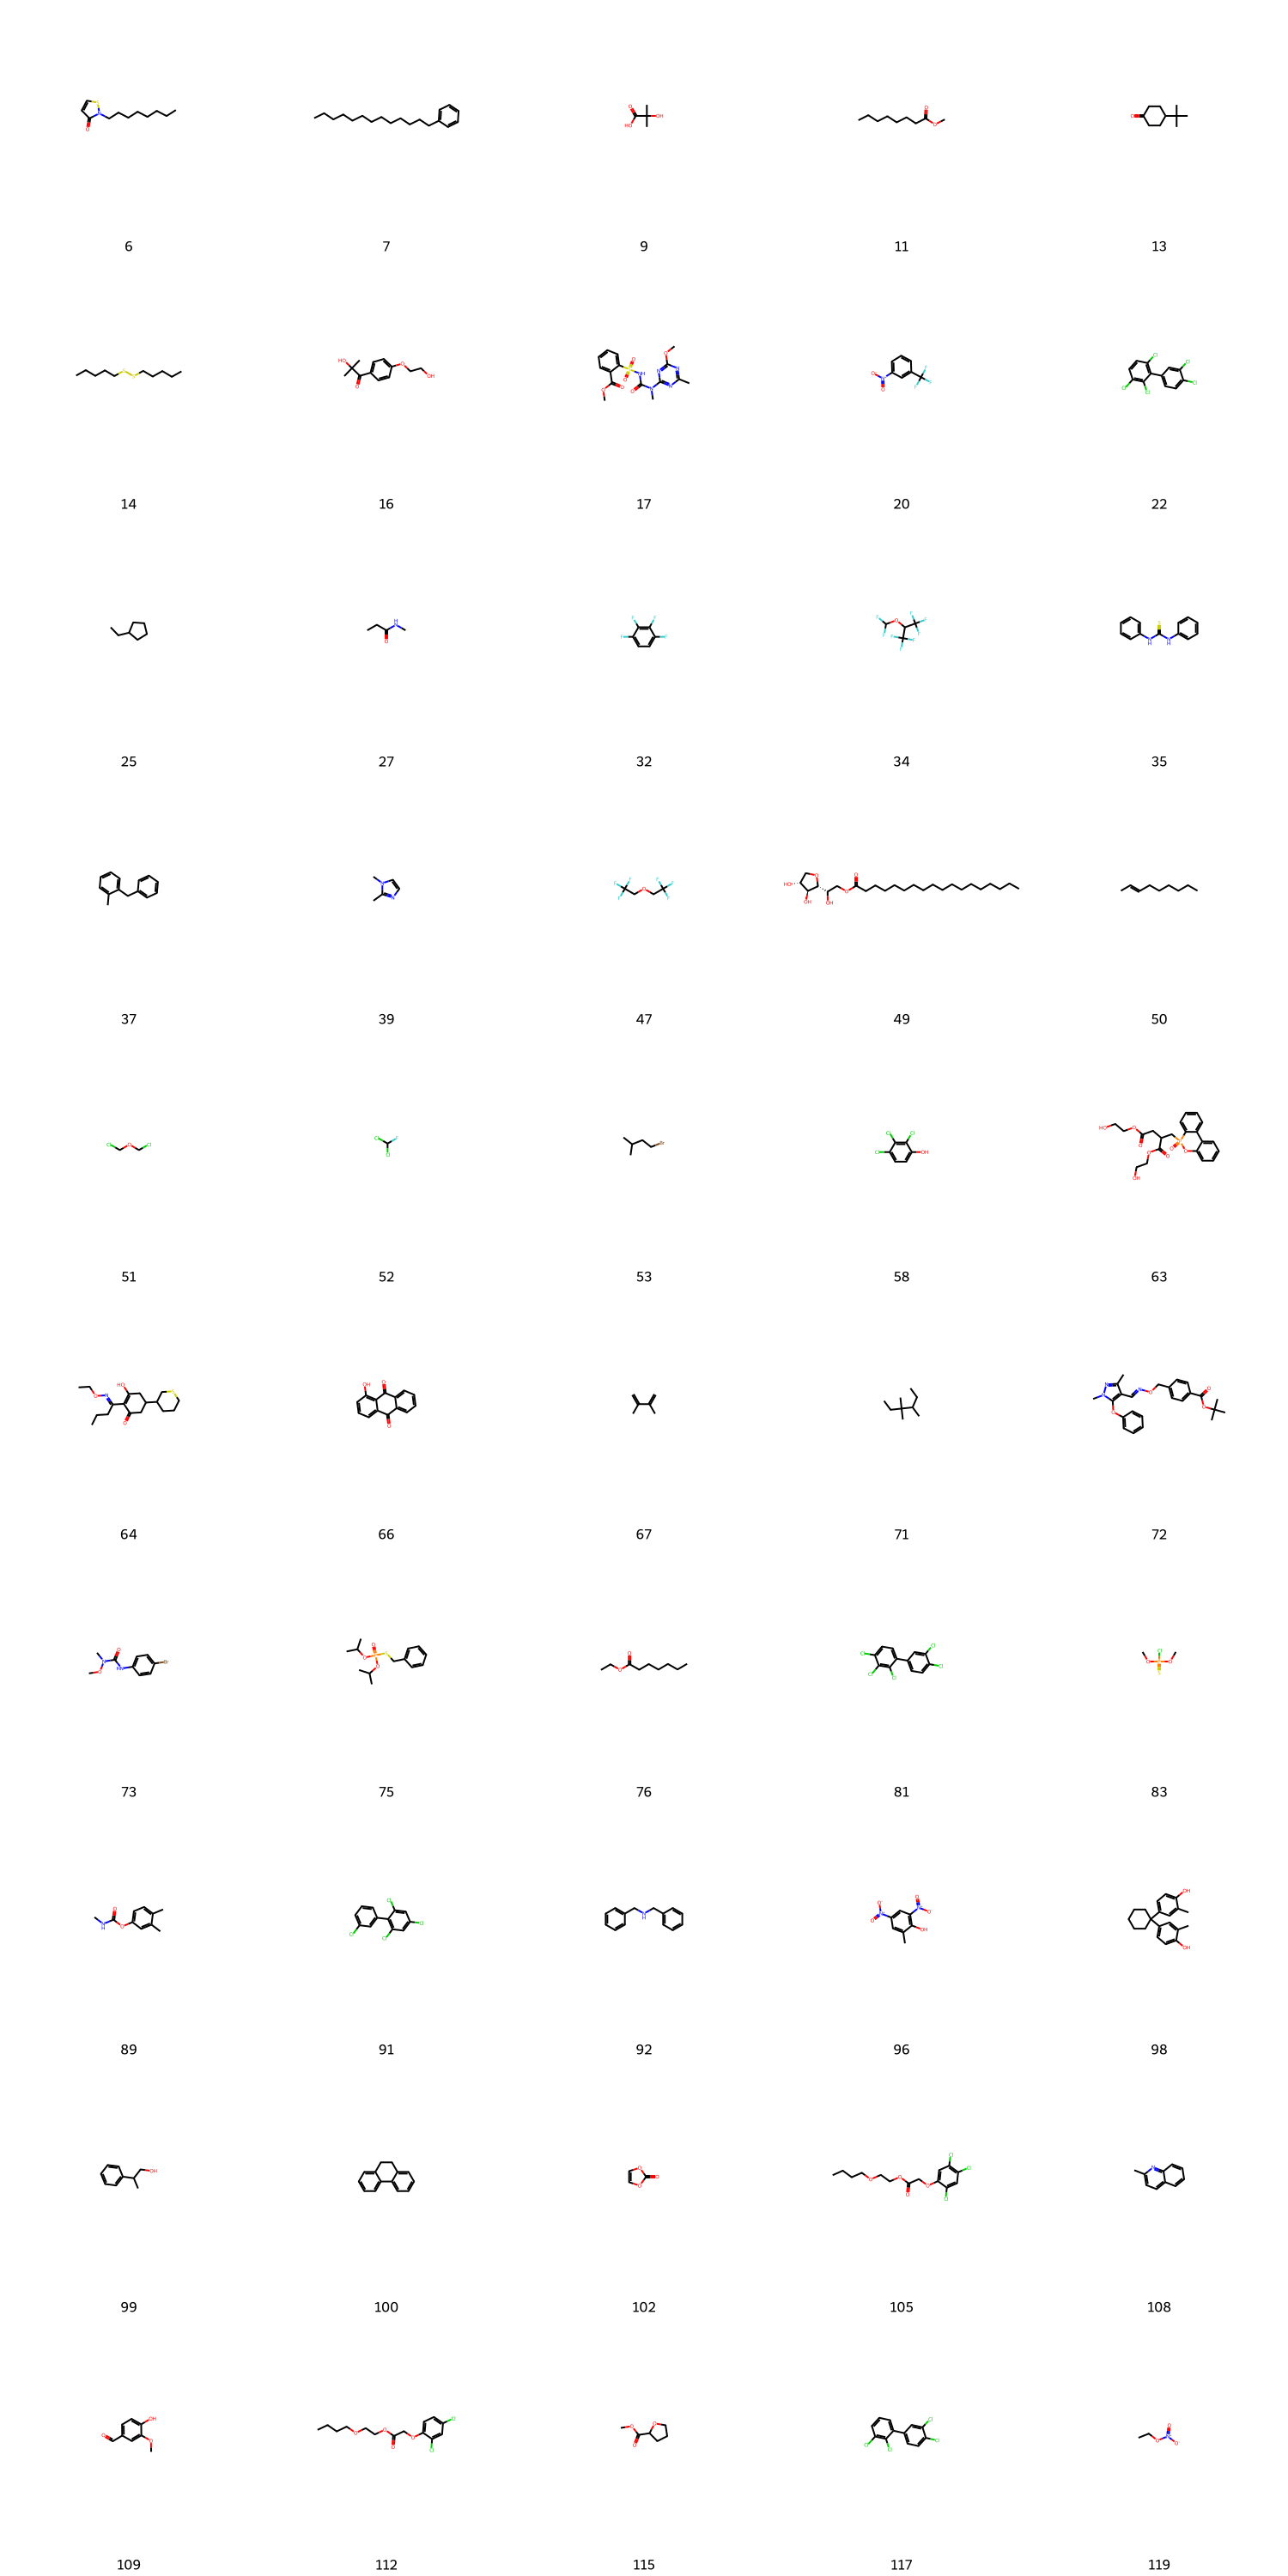

In [15]:
mols = [Chem.MolFromSmiles(s) for s in smiles]
from rdkit.Chem import Draw
Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(300,300), legends=[str(x) for x in molregnos_mdfp_better])

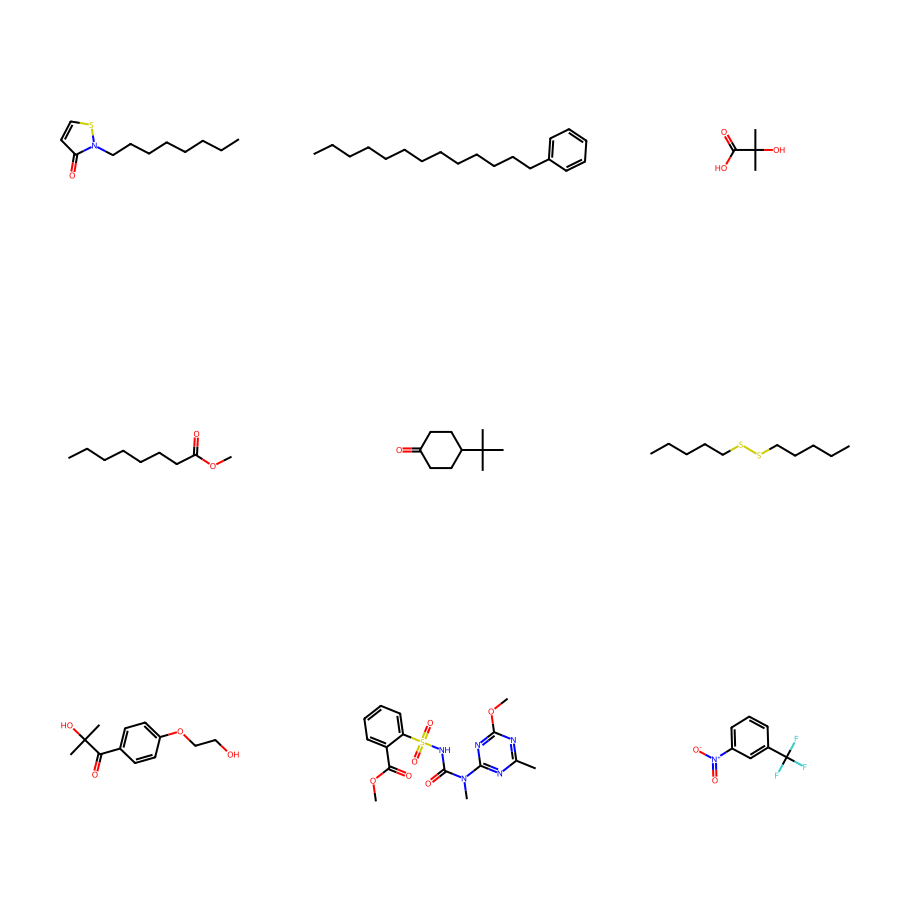

In [16]:
mols = [Chem.MolFromSmiles(s) for s in smiles]
molregnos 
from rdkit.Chem import Draw
Draw.MolsToGridImage(mols[:9], molsPerRow=3, subImgSize=(300,300))

Text(0.5, 1.0, 'Number of molecules per bin of experimental vp values')

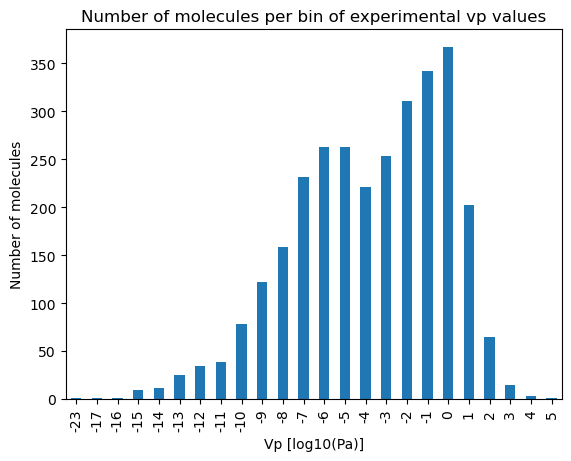

In [13]:
#look at difference in prediction error per bin of experimental vp values. Bin per 1 log unit
df_preds['vp_bin'] = np.floor(df_preds['vp'])
df_preds['vp_bin'] = df_preds['vp_bin'].astype(int)
df_preds['vp_bin'].value_counts()
df_preds['vp_bin'].value_counts().sort_index()
df_preds['vp_bin'].value_counts().sort_index().plot.bar()
plt.ylabel('Number of molecules')
plt.xlabel('Vp [log10(Pa)]')
plt.title('Number of molecules per bin of experimental vp values')


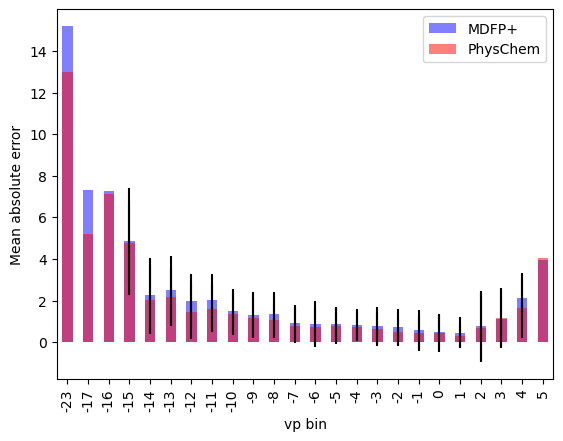

In [12]:
import matplotlib.pyplot as plt

# assuming df_preds is your DataFrame
fig, ax = plt.subplots()
mean_mdfp = df_preds['abs_error_mdfp'].groupby(df_preds['vp_bin']).mean()
std_mdfp = df_preds['abs_error_mdfp'].groupby(df_preds['vp_bin']).std()
mean_2d = df_preds['abs_error_2d'].groupby(df_preds['vp_bin']).mean()
std_2d = df_preds['abs_error_2d'].groupby(df_preds['vp_bin']).std()
datapoints = df_preds['abs_error_2d'].groupby(df_preds['vp_bin']).count()
mean_mdfp.plot.bar(ax=ax, color='blue', alpha=0.5, yerr=std_mdfp)
mean_2d.plot.bar(ax=ax, color='red', alpha=0.5, yerr=std_2d)
ax.legend(['MDFP+','PhysChem'])
ax.set_xlabel('vp bin')
ax.set_ylabel('Mean absolute error')
plt.show()

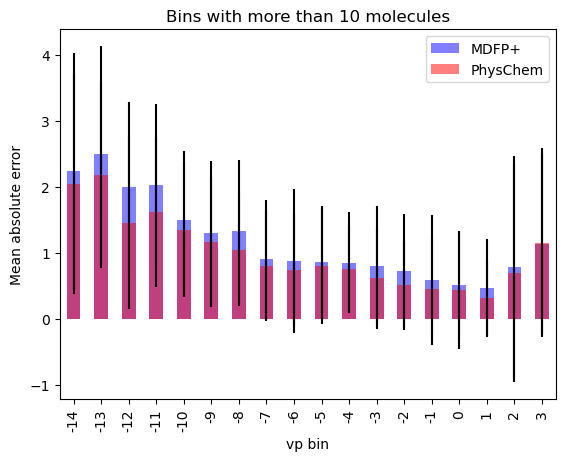

In [18]:
import matplotlib.pyplot as plt

# assuming df_preds is your DataFrame
fig, ax = plt.subplots()
datapoints = df_preds['abs_error_2d'].groupby(df_preds['vp_bin']).count()
bins_with_more_than_50 = datapoints[datapoints > 10].index

mean_mdfp = df_preds[df_preds['vp_bin'].isin(bins_with_more_than_50)]['abs_error_mdfp'].groupby(df_preds['vp_bin']).mean()
std_mdfp = df_preds[df_preds['vp_bin'].isin(bins_with_more_than_50)]['abs_error_mdfp'].groupby(df_preds['vp_bin']).std()
mean_2d = df_preds[df_preds['vp_bin'].isin(bins_with_more_than_50)]['abs_error_2d'].groupby(df_preds['vp_bin']).mean()
std_2d = df_preds[df_preds['vp_bin'].isin(bins_with_more_than_50)]['abs_error_2d'].groupby(df_preds['vp_bin']).std()

mean_mdfp.plot.bar(ax=ax, color='blue', alpha=0.5, yerr=std_mdfp)
mean_2d.plot.bar(ax=ax, color='red', alpha=0.5, yerr=std_2d)
ax.legend(['MDFP+','PhysChem'])
ax.set_xlabel('vp bin')
ax.set_ylabel('Mean absolute error')
ax.set_title('Bins with more than 10 molecules')
plt.show()

/tmp/ipykernel_568731/1316450871.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  mean_mdfp_percentages = [mean_mdfp[mean_mdfp.index[i]] /mean_mdfp.index[i] * 100 for i in range(len(mean_mdfp))]
/tmp/ipykernel_568731/1316450871.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  std_mdfp_percentages = [std_mdfp[mean_mdfp.index[i]] /mean_mdfp.index[i] * 100 for i in range(len(mean_mdfp))]
/tmp/ipykernel_568731/1316450871.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  mean_2d_percentages = [mean_2d[mean_mdfp.index[i]] /mean_mdfp.index[i] * 100 for i in range(len(mean_mdfp))]
/tmp/ipykernel_568731/1316450871.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  std_2d_percentages = [std_2d[mean_mdfp.index[i]] /mean_mdfp.index[i] * 100 for i in range(len(mean_mdfp))]
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/matplotlib/axes/_axes.py:3680: RuntimeWarning: invalid value encountered in scalar

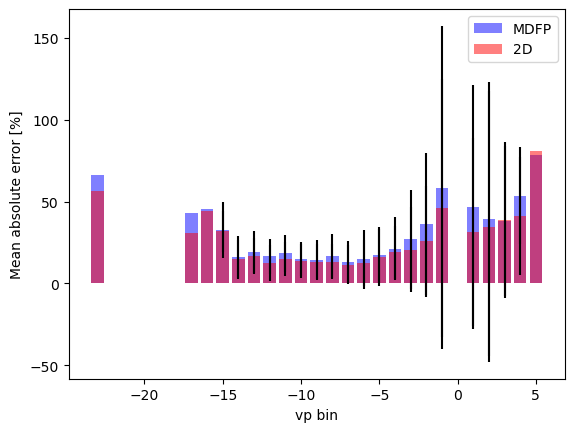

In [19]:
mean_mdfp.index[0]
mean_mdfp_percentages = [mean_mdfp[mean_mdfp.index[i]] /mean_mdfp.index[i] * 100 for i in range(len(mean_mdfp))]
std_mdfp_percentages = [std_mdfp[mean_mdfp.index[i]] /mean_mdfp.index[i] * 100 for i in range(len(mean_mdfp))]
mean_2d_percentages = [mean_2d[mean_mdfp.index[i]] /mean_mdfp.index[i] * 100 for i in range(len(mean_mdfp))]
std_2d_percentages = [std_2d[mean_mdfp.index[i]] /mean_mdfp.index[i] * 100 for i in range(len(mean_mdfp))]
std_2d_percentages = [abs(x) for x in std_2d_percentages]
std_mdfp_percentages = [abs(x) for x in std_mdfp_percentages]
mean_mdfp_percentages = [abs(x) for x in mean_mdfp_percentages]
mean_2d_percentages = [abs(x) for x in mean_2d_percentages]
#barplot
import matplotlib.pyplot as plt
plt, ax = plt.subplots()
ax.bar(mean_mdfp.index, mean_mdfp_percentages, yerr=std_mdfp_percentages, color='blue', alpha=0.5)
ax.bar(mean_2d.index, mean_2d_percentages, yerr=std_2d_percentages, color='red', alpha=0.5)
ax.legend(['MDFP','2D'])
ax.set_xlabel('vp bin')
ax.set_ylabel('Mean absolute error [%]')
# for i, v in enumerate(datapoints):
#     x = mean_2d.index[i]
#     y = mean_mdfp_percentages[i]
#     if str(std_mdfp_percentages[i]) != "nan":
#         y += std_mdfp_percentages[x]
#     ax.text(x, y, str(v), color='black', fontweight='bold', ha='center', va='bottom',fontsize=6)

plt.show()

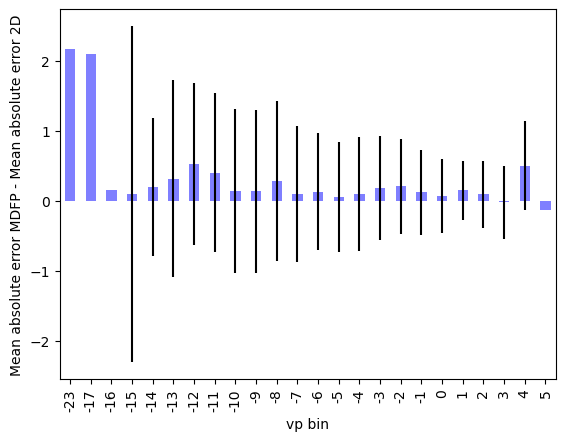

In [20]:
import matplotlib.pyplot as plt

# assuming df_preds is your DataFrame
fig, ax = plt.subplots()
mean_diff = (df_preds['abs_error_mdfp'] - df_preds['abs_error_2d']).groupby(df_preds['vp_bin']).mean()
std_diff = (df_preds['abs_error_mdfp'] - df_preds['abs_error_2d']).groupby(df_preds['vp_bin']).std()
datapoints = (df_preds['abs_error_mdfp'] - df_preds['abs_error_2d']).groupby(df_preds['vp_bin']).count()
mean_diff.plot.bar(ax=ax, color='blue', alpha=0.5, yerr=std_diff)
ax.set_xlabel('vp bin')
ax.set_ylabel('Mean absolute error MDFP - Mean absolute error 2D')
plt.show()

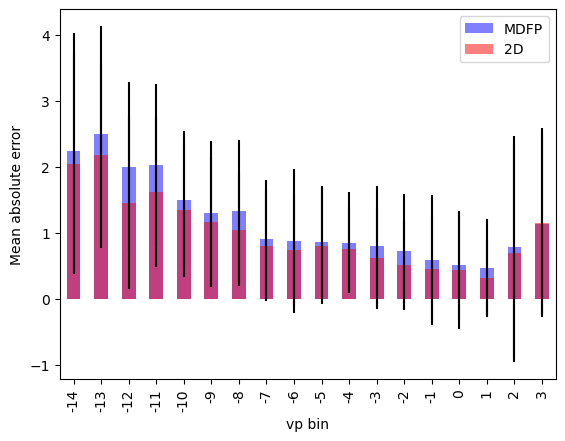

In [21]:
#look only at data with >10 datapoints per bin
#count datapoints per bin
datapoints = df_preds['abs_error_2d'].groupby(df_preds['vp_bin']).count()
bins_with_10_datapoints = datapoints[datapoints > 10].index.tolist()    

import matplotlib.pyplot as plt
#plot only bins with >10 datapoints
# assuming df_preds is your DataFrame
fig, ax = plt.subplots()
df_preds_10 = df_preds[df_preds['vp_bin'].isin(bins_with_10_datapoints)]
mean_mdfp = df_preds_10['abs_error_mdfp'].groupby(df_preds_10['vp_bin']).mean()
std_mdfp = df_preds_10['abs_error_mdfp'].groupby(df_preds_10['vp_bin']).std()
mean_2d = df_preds_10['abs_error_2d'].groupby(df_preds_10['vp_bin']).mean()
std_2d = df_preds_10['abs_error_2d'].groupby(df_preds_10['vp_bin']).std()
datapoints = df_preds_10['abs_error_2d'].groupby(df_preds_10['vp_bin']).count()
mean_mdfp.plot.bar(ax=ax, color='blue', alpha=0.5, yerr=std_mdfp)
mean_2d.plot.bar(ax=ax, color='red', alpha=0.5, yerr=std_2d)
ax.legend(['MDFP','2D'])
ax.set_xlabel('vp bin')
ax.set_ylabel('Mean absolute error')
plt.show()




In [40]:
import sys
sys.path.append('../')
from carl.utils_carl import get_mdfps
df_mdfps = get_mdfps(which='one_5ns')
df_new_confs = get_mdfps(which='five_5ns')

data_full = pd.concat([df_mdfps,df_new_confs])

2980 results fetched
['confid', 'molregno', 'mdfp', 'vp_log10pa']
11023 results fetched
['confid', 'molregno', 'mdfp', 'vp_log10pa']


In [42]:
df_physchem = pd.read_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/Experiments_result_analysis/mdfp_and_rdkit_features_2980.csv')
RDKit_feature_names = pd.read_pickle('/localhome/cschiebroek/MDFPs/mdfptools/carl/data/outputs/RDKit_2D_descriptors.pkl')

In [43]:
#get a dict mapping molregno to each feature
molregno_to_physchem = {}
for i in range(len(df_physchem)):
    molregno_to_physchem[df_physchem['molregno'].iloc[i]] = df_physchem.iloc[i].to_dict()

In [45]:
data_full['molregno'].tlist

0        2390
1        2396
2        2402
3        2408
4        2413
         ... 
11018    3539
11019    3539
11020    3539
11021    3539
11022    3539
Name: molregno, Length: 14003, dtype: int64

In [49]:
molregnos = data_full['molregno'].tolist()
for feature in RDKit_feature_names:
    l1 = []
    for molregno in molregnos:
        l1.append(molregno_to_physchem[molregno][feature])
    data_full[feature] = l1
data_full.to_csv('mdfp_and_rdkit_features_augmented.csv')


In [53]:
import pandas as pd
#split list in column "mdfp" into seperate columns: column names from mdfp_feature_names
mdfp_features_all = ['NumHeavyAtoms', 'NumRotatableBonds', 'NumN', 'NumO', 'NumF', 'NumP', 'NumS', 'NumCl', 'NumBr', 'NumI', 'water_intra_crf_mean', 'water_intra_crf_std', 'water_intra_crf_median', 'water_intra_lj_mean', 'water_intra_lj_std', 'water_intra_lj_median', 'water_total_crf_mean', 'water_total_crf_std', 'water_total_crf_median', 'water_total_lj_mean', 'water_total_lj_std', 'water_total_lj_median', 'water_intra_ene_mean', 'water_intra_ene_std', 'water_intra_ene_median', 'water_total_ene_mean', 'water_total_ene_std', 'water_total_ene_median', 'water_rgyr_mean', 'water_rgyr_std', 'water_rgyr_median', 'water_sasa_mean', 'water_sasa_std', 'water_sasa_median']

# use apply method to split the list into separate columns
data_full[mdfp_features_all] = data_full['mdfp'].apply(lambda x: pd.Series(x))

# print the resulting dataframe


       confid  molregno                                               mdfp  \
0        2388      2390  [10, 1, 0, 0, 0, 0, 0, 0, 0, 0, -24.3637634540...   
1        2394      2396  [7, 4, 0, 1, 0, 0, 0, 0, 0, 0, -4.742220929815...   
2        2400      2402  [10, 2, 2, 0, 0, 0, 0, 0, 0, 0, -13.4724999801...   
3        2406      2408  [14, 3, 4, 3, 0, 0, 0, 0, 0, 0, -411.884680244...   
4        2411      2413  [15, 2, 0, 1, 0, 0, 0, 0, 2, 0, -36.3113182099...   
...       ...       ...                                                ...   
11018   15530      3539  [44, 35, 2, 4, 0, 0, 0, 0, 0, 0, -285.66340740...   
11019   15531      3539  [44, 35, 2, 4, 0, 0, 0, 0, 0, 0, -287.85335624...   
11020   15529      3539  [44, 35, 2, 4, 0, 0, 0, 0, 0, 0, -286.74305751...   
11021   15532      3539  [44, 35, 2, 4, 0, 0, 0, 0, 0, 0, -284.52836303...   
11022   15533      3539  [44, 35, 2, 4, 0, 0, 0, 0, 0, 0, -286.74777273...   

             vp  MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStat

/tmp/ipykernel_568731/3504025004.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_full[mdfp_features_all] = data_full['mdfp'].apply(lambda x: pd.Series(x))
/tmp/ipykernel_568731/3504025004.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_full[mdfp_features_all] = data_full['mdfp'].apply(lambda x: pd.Series(x))
/tmp/ipykernel_568731/3504025004.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all

In [54]:
data_full

,confid,molregno,mdfp,vp,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,AvgIpc,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,fr_C_O,fr_C_O_noCOO,fr_C_S,fr_HOCCN,fr_Imine,fr_NH0,fr_NH1,fr_NH2,fr_N_O,fr_Ndealkylation1,fr_Ndealkylation2,fr_Nhpyrrole,fr_SH,fr_aldehyde,fr_alkyl_carbamate,fr_alkyl_halide,fr_allylic_oxid,fr_amide,fr_amidine,fr_aniline,fr_aryl_methyl,fr_azide,fr_azo,fr_barbitur,fr_benzene,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,NumHeavyAtoms,NumN,NumO,NumF,NumP,NumS,NumCl,NumBr,NumI,water_intra_crf_mean,water_intra_crf_std,water_intra_crf_median,water_intra_lj_mean,water_intra_lj_std,water_intra_lj_median,water_total_crf_mean,water_total_crf_std,water_total_crf_median,water_total_lj_mean,water_total_lj_std,water_total_lj_median,water_intra_ene_mean,water_intra_ene_std,water_intra_ene_median,water_total_ene_mean,water_total_ene_std,water_total_ene_median,water_rgyr_mean,water_rgyr_std,water_rgyr_median,water_sasa_mean,water_sasa_std,water_sasa_median
0,2388,2390,"[10, 1, 0, 0, 0, 0, 0, 0, 0, 0, -24.3637634540...",2.325205,8.278588,8.278588,1.227955,-4.010932,0.519119,136.238,120.110,136.125201,56,0,0.062213,-0.095843,0.095843,0.062213,2.300000,3.200000,3.900000,-1.283991e-15,-0.244977,-1.951611e-02,-2.725481,-3.158142e-16,-2.625831,-5.512032e-16,-1.126905,2.392061,4.217959,641.498397,21.309401,21.000000,5.000000,11.136751,10.500000,2.500000,1.625000,1.625000,0.875000,0.875000,0.437500,0.437500,-0.52,9.175947e+04,1.050029,3.046280,1.728510,86.118221,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,37.912071,24.533765,16.449103,5.483034,21.932137,0.000000,0.000000,0.000000,11.787915,26.449634,0.000000,24.208287,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.787915,48.381771,24.208287,0.000000,0.0,0.0,0.00,62.445836,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,21.932137,122.698580,0.000000,0.000000,0.000000,-1.227955,-7.875978,-2

In [75]:
#okay, now I actually want to look at prediction error of only 2d vs only mdfp per mol, and look at the difference
df = data_full
params = {
    'max_depth':9,
    'min_child_weight': 4,
    'eta':.05,
    'subsample': 1,
    'colsample_bytree': 0.5,
} #hyperparameters optimized for augmented dataset
import numpy as np
from sklearn.model_selection import GroupKFold, KFold
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
gkf = GroupKFold(n_splits=5)

# Create an empty list to store the indices of each fold
fold_indices = []
# Group the data by 'molregno'
groups = df['molregno']

# Iterate over each fold
for train_idx, test_idx in gkf.split(df, groups=groups):
    fold_indices.append((train_idx, test_idx))
mdfp_features_all = ['NumHeavyAtoms', 'NumRotatableBonds', 'NumN', 'NumO', 'NumF', 'NumP', 'NumS', 'NumCl', 'NumBr', 'NumI', 'water_intra_crf_mean', 'water_intra_crf_std', 'water_intra_crf_median', 'water_intra_lj_mean', 'water_intra_lj_std', 'water_intra_lj_median', 'water_total_crf_mean', 'water_total_crf_std', 'water_total_crf_median', 'water_total_lj_mean', 'water_total_lj_std', 'water_total_lj_median', 'water_intra_ene_mean', 'water_intra_ene_std', 'water_intra_ene_median', 'water_total_ene_mean', 'water_total_ene_std', 'water_total_ene_median', 'water_rgyr_mean', 'water_rgyr_std', 'water_rgyr_median', 'water_sasa_mean', 'water_sasa_std', 'water_sasa_median']
combined_features = RDKit_feature_names + mdfp_features_all
y = df['vp']  
params = params
output = ([],[],[],[],[],[])
selection_2d_features = RDKit_feature_names

X_mdfp = df[mdfp_features_all]
X_mdfp = StandardScaler().fit_transform(X_mdfp)
X_2d = df[selection_2d_features]
X_2d = StandardScaler().fit_transform(X_2d)
x_combined = df[combined_features]
x_combined = StandardScaler().fit_transform(x_combined)
y = df['vp'].to_numpy()
# Iterate over each fold
for fold, (train_idx, test_idx) in enumerate(fold_indices):

    #get the train and test data
    X_train_mdfp = X_mdfp[train_idx]
    X_test_mdfp = X_mdfp[test_idx]
    X_train_2d = X_2d[train_idx]
    X_test_2d = X_2d[test_idx]
    y_train = y[train_idx]
    y_test = y[test_idx]
    X_train_combined = x_combined[train_idx]
    X_test_combined = x_combined[test_idx]




    # Create DMatrix for training and testing
    dtrain_mdfp = xgb.DMatrix(X_train_mdfp, label=y_train)
    dtest_mdfp = xgb.DMatrix(X_test_mdfp, label=y_test)

    dtrain_2d = xgb.DMatrix(X_train_2d, label=y_train)
    dtest_2d = xgb.DMatrix(X_test_2d, label=y_test)

    dtrain_combined = xgb.DMatrix(X_train_combined, label=y_train)
    dtest_combined = xgb.DMatrix(X_test_combined, label=y_test)


    model_mdfp = xgb.train(
        params,
        dtrain_mdfp,
        num_boost_round=999,
        evals=[(dtest_mdfp, "Test")],
        early_stopping_rounds=10,
        verbose_eval=False

    )

    model_2d = xgb.train(
        params,
        dtrain_2d,
        num_boost_round=999,
        evals=[(dtest_2d, "Test")],
        early_stopping_rounds=10,
        verbose_eval=False

    )

    model_combined = xgb.train(
        params,
        dtrain_combined,
        num_boost_round=999,
        evals=[(dtest_combined, "Test")],
        early_stopping_rounds=10,
        verbose_eval=False

    )

    pp_mdfp = model_mdfp.predict(dtest_mdfp)
    pp_2d = model_2d.predict(dtest_2d)
    pp_combined = model_combined.predict(dtest_combined)

    output[0].append(y_test)
    output[1].append(pp_mdfp)
    molregnos_test = df['molregno'].iloc[test_idx]
    confids_test = df['confid'].iloc[test_idx]
    
    output[2].append(molregnos_test)
    output[3].append(confids_test)
    output[4].append(pp_2d)
    output[5].append(pp_combined)

    rmse_mdfp = np.sqrt(mean_squared_error(y_test, pp_mdfp, squared=False))
    rmse_2d = np.sqrt(mean_squared_error(y_test, pp_2d, squared=False))
    rmse_combined = np.sqrt(mean_squared_error(y_test, pp_combined, squared=False))
    print(f"Fold {fold + 1}: MDFP RMSE = {rmse_mdfp}, 2D RMSE = {rmse_2d}, combined RMSE = {rmse_combined}")



Fold 1: MDFP RMSE = 1.1784476874986825, 2D RMSE = 1.142497427080294, combined RMSE = 1.1475896171725948
Fold 2: MDFP RMSE = 1.2505413639309084, 2D RMSE = 1.1673159236443984, combined RMSE = 1.1923054555086903
Fold 3: MDFP RMSE = 1.0953961131419252, 2D RMSE = 1.0340732635816368, combined RMSE = 1.0363057884060818
Fold 4: MDFP RMSE = 1.101377801689998, 2D RMSE = 1.0637572857383766, combined RMSE = 1.0641393943562079
Fold 5: MDFP RMSE = 1.2685576864752095, 2D RMSE = 1.1557867139856672, combined RMSE = 1.1518344605504791


In [76]:
#average over conformers
vps = reduce(lambda a,b : list(a)+list(b) , output[0])
preds_mdfp = reduce(lambda a,b : list(a)+list(b), output[1])
molregnos = reduce(lambda a,b : list(a)+list(b), output[2])
confids = reduce(lambda a,b : list(a)+list(b), output[3])
preds_2d = reduce(lambda a,b : list(a)+list(b), output[4])
preds_combined = reduce(lambda a,b : list(a)+list(b), output[5])
df_preds = pd.DataFrame({'vp': vps, 'pred_mdfp': preds_mdfp, 'pred_2d': preds_2d, 'confid': confids, 'molregno': molregnos, 'pred_combined': preds_combined})
df_preds = df_preds.groupby('molregno').mean()
#drop confid
df_preds = df_preds.drop(columns=['confid'])
#get abs error for both preds
df_preds['abs_error_mdfp'] = abs(df_preds['vp'] - df_preds['pred_mdfp'])
df_preds['abs_error_2d'] = abs(df_preds['vp'] - df_preds['pred_2d'])
df_preds['abs_error_combined'] = abs(df_preds['vp'] - df_preds['pred_combined'])
df_preds

,vp,pred_mdfp,pred_2d,pred_combined,abs_error_mdfp,abs_error_2d,abs_error_combined
molregno,,,,,,,
1,4.100855,4.012758,4.077096,3.925213,0.088097,0.023759,0.175642
6,-11.744727,-4.949354,-5.683266,-5.264895,6.795374,6.061461,6.479833
7,2.698933,2.446294,2.836136,2.783381,0.252639,0.137203,0.084447
8,-3.053323,-3.076710,-3.012222,-2.932419,0.023387,0.041100,0.120904
9,3.591625,3.422963,3.616429,3.424995,0.168662,0.024805,0.166630
...,...,...,...,...,...,...,...
4240,-4.301899,-4.221007,-4.323608,-4.519409,0.080893,0.021709,0.217509
4241,-5.356584,-5.229311,-5.600667,-5.609240,0.127273,0.244083,0.252655
4242,-3.770000,-3.579237,-3.558295,-3.610788,0.190763,0.211705,0.159212


Plot 1 Stats:
RMSE:  1.3253927068866616
MAE:  0.7793149760120497
R2:  0.8655926563636731
Plot 2 Stats:
RMSE:  1.1884236908671935
MAE:  0.6661001939822048
R2:  0.8919749535817786
Plot 3 Stats:
RMSE:  1.1975270685316988
MAE:  0.6636903752840874
R2:  0.8903371154687588


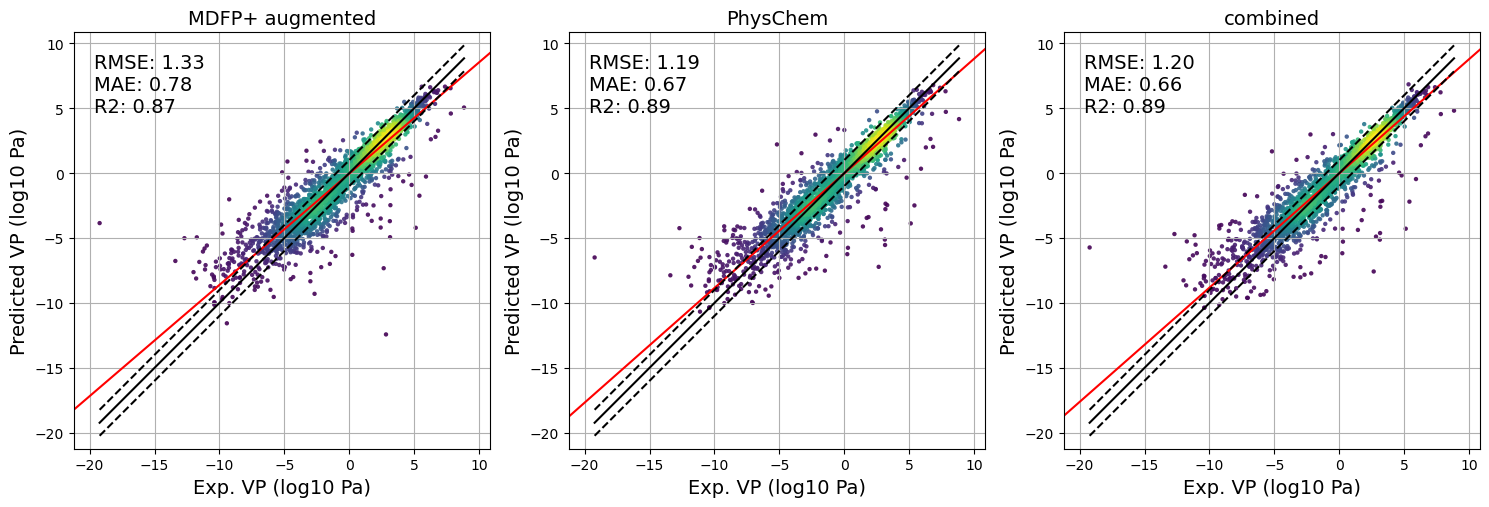

In [78]:
real = df_preds['vp'].tolist()
prediction_mdfp = df_preds['pred_mdfp'].tolist()
prediction_2d = df_preds['pred_2d'].tolist()
prediction_combined = df_preds['pred_combined'].tolist()
density_plot_multiple(reals = [real,real,real],predictions=[prediction_mdfp,prediction_2d,prediction_combined],titles = ['MDFP+ augmented','PhysChem','combined'])

In [62]:
y_train = y[train_idx]

KeyError: '[11023, 11027, 11029, 11032, 11033, 11034, 11035, 11036, 11038, 11041, 11043, 11044, 11045, 11047, 11048, 11049, 11050, 11051, 11052, 11053, 11054, 11055, 11057, 11059, 11062, 11063, 11064, 11065, 11066, 11067, 11068, 11069, 11070, 11071, 11072, 11077, 11078, 11079, 11080, 11081, 11082, 11083, 11084, 11085, 11086, 11087, 11088, 11089, 11091, 11092, 11093, 11094, 11095, 11096, 11097, 11098, 11099, 11101, 11102, 11103, 11108, 11110, 11111, 11112, 11113, 11114, 11116, 11119, 11120, 11121, 11122, 11123, 11124, 11125, 11126, 11127, 11128, 11129, 11130, 11131, 11132, 11133, 11134, 11135, 11136, 11137, 11138, 11139, 11140, 11141, 11142, 11143, 11144, 11145, 11146, 11147, 11148, 11149, 11150, 11151, 11152, 11153, 11154, 11155, 11156, 11157, 11158, 11162, 11164, 11166, 11167, 11168, 11169, 11170, 11171, 11172, 11173, 11174, 11175, 11178, 11181, 11183, 11184, 11185, 11186, 11187, 11188, 11190, 11191, 11192, 11193, 11194, 11196, 11197, 11201, 11204, 11206, 11210, 11212, 11213, 11214, 11215, 11216, 11217, 11219, 11220, 11224, 11227, 11228, 11229, 11230, 11231, 11232, 11233, 11234, 11235, 11238, 11242, 11245, 11246, 11247, 11248, 11251, 11254, 11255, 11256, 11257, 11259, 11262, 11264, 11267, 11271, 11273, 11279, 11284, 11285, 11290, 11292, 11293, 11294, 11295, 11296, 11297, 11299, 11300, 11301, 11302, 11303, 11304, 11305, 11306, 11307, 11308, 11309, 11310, 11311, 11312, 11313, 11314, 11315, 11316, 11317, 11318, 11319, 11320, 11321, 11322, 11323, 11324, 11325, 11326, 11327, 11328, 11329, 11331, 11332, 11333, 11334, 11335, 11336, 11337, 11338, 11339, 11340, 11341, 11342, 11343, 11344, 11345, 11346, 11347, 11348, 11349, 11350, 11351, 11352, 11353, 11354, 11355, 11356, 11359, 11360, 11361, 11363, 11364, 11365, 11366, 11367, 11368, 11371, 11372, 11373, 11374, 11375, 11376, 11377, 11378, 11381, 11382, 11383, 11387, 11388, 11389, 11390, 11391, 11392, 11399, 11401, 11402, 11403, 11404, 11406, 11409, 11410, 11411, 11412, 11413, 11414, 11415, 11416, 11417, 11419, 11420, 11421, 11422, 11423, 11424, 11425, 11426, 11427, 11428, 11429, 11430, 11432, 11433, 11435, 11436, 11437, 11438, 11439, 11440, 11441, 11442, 11443, 11444, 11445, 11447, 11448, 11449, 11451, 11453, 11455, 11456, 11457, 11458, 11459, 11460, 11462, 11463, 11465, 11466, 11467, 11468, 11469, 11470, 11471, 11472, 11473, 11474, 11476, 11477, 11479, 11480, 11481, 11483, 11484, 11485, 11486, 11487, 11488, 11489, 11490, 11491, 11492, 11493, 11494, 11495, 11496, 11497, 11498, 11499, 11500, 11501, 11503, 11504, 11505, 11507, 11510, 11512, 11514, 11515, 11516, 11518, 11523, 11524, 11526, 11527, 11528, 11529, 11531, 11532, 11533, 11534, 11535, 11536, 11537, 11538, 11539, 11540, 11542, 11549, 11550, 11551, 11552, 11553, 11554, 11555, 11556, 11557, 11559, 11560, 11561, 11562, 11563, 11564, 11565, 11566, 11567, 11568, 11569, 11570, 11573, 11575, 11576, 11577, 11583, 11584, 11585, 11586, 11587, 11588, 11589, 11590, 11592, 11593, 11594, 11595, 11596, 11597, 11598, 11599, 11600, 11601, 11602, 11603, 11605, 11607, 11608, 11609, 11610, 11611, 11612, 11614, 11616, 11618, 11619, 11620, 11622, 11623, 11625, 11626, 11627, 11628, 11629, 11630, 11631, 11632, 11633, 11634, 11635, 11636, 11637, 11639, 11641, 11642, 11643, 11644, 11645, 11646, 11647, 11649, 11650, 11651, 11652, 11653, 11654, 11655, 11656, 11657, 11658, 11659, 11660, 11661, 11662, 11663, 11664, 11665, 11666, 11667, 11668, 11669, 11670, 11671, 11672, 11673, 11674, 11677, 11679, 11680, 11682, 11684, 11685, 11686, 11687, 11688, 11689, 11690, 11691, 11694, 11695, 11696, 11697, 11698, 11699, 11700, 11701, 11702, 11703, 11704, 11705, 11706, 11707, 11708, 11709, 11711, 11712, 11713, 11714, 11715, 11716, 11717, 11718, 11719, 11720, 11721, 11722, 11723, 11724, 11725, 11726, 11727, 11732, 11735, 11736, 11737, 11738, 11739, 11740, 11741, 11742, 11743, 11744, 11745, 11746, 11747, 11748, 11749, 11750, 11751, 11752, 11753, 11754, 11755, 11757, 11759, 11760, 11761, 11762, 11763, 11764, 11769, 11770, 11773, 11775, 11777, 11778, 11779, 11780, 11781, 11782, 11783, 11784, 11785, 11786, 11787, 11788, 11789, 11790, 11791, 11792, 11793, 11794, 11795, 11796, 11797, 11798, 11799, 11800, 11801, 11802, 11803, 11804, 11805, 11806, 11807, 11809, 11810, 11811, 11812, 11813, 11814, 11815, 11817, 11818, 11819, 11820, 11821, 11822, 11823, 11824, 11825, 11826, 11827, 11829, 11830, 11831, 11832, 11833, 11834, 11835, 11836, 11838, 11839, 11843, 11844, 11846, 11847, 11848, 11849, 11850, 11851, 11852, 11853, 11854, 11855, 11856, 11857, 11859, 11860, 11861, 11863, 11864, 11868, 11869, 11870, 11871, 11872, 11874, 11875, 11876, 11877, 11878, 11879, 11880, 11881, 11882, 11883, 11884, 11885, 11886, 11887, 11888, 11889, 11890, 11891, 11892, 11893, 11894, 11895, 11896, 11897, 11898, 11899, 11900, 11901, 11902, 11903, 11907, 11909, 11910, 11912, 11913, 11916, 11919, 11921, 11922, 11923, 11925, 11926, 11927, 11928, 11929, 11930, 11933, 11936, 11938, 11940, 11942, 11943, 11944, 11946, 11947, 11948, 11949, 11950, 11951, 11952, 11953, 11954, 11955, 11956, 11958, 11959, 11960, 11961, 11962, 11963, 11964, 11965, 11966, 11967, 11968, 11969, 11970, 11972, 11974, 11976, 11977, 11978, 11979, 11980, 11981, 11982, 11988, 11989, 11991, 11992, 11993, 11994, 11995, 11997, 11999, 12004, 12005, 12007, 12008, 12010, 12014, 12020, 12021, 12023, 12025, 12027, 12028, 12029, 12030, 12031, 12032, 12033, 12040, 12041, 12042, 12045, 12046, 12047, 12048, 12049, 12050, 12051, 12052, 12053, 12054, 12055, 12056, 12057, 12058, 12059, 12060, 12061, 12062, 12063, 12064, 12065, 12066, 12067, 12068, 12069, 12070, 12071, 12072, 12073, 12074, 12075, 12076, 12077, 12078, 12079, 12080, 12081, 12082, 12083, 12084, 12085, 12086, 12087, 12088, 12089, 12090, 12091, 12092, 12093, 12094, 12095, 12096, 12097, 12098, 12099, 12100, 12101, 12102, 12103, 12104, 12105, 12106, 12107, 12108, 12109, 12110, 12111, 12112, 12114, 12115, 12116, 12118, 12119, 12120, 12121, 12122, 12123, 12124, 12125, 12126, 12127, 12128, 12129, 12130, 12131, 12132, 12133, 12134, 12135, 12136, 12137, 12138, 12139, 12140, 12141, 12142, 12143, 12144, 12145, 12146, 12147, 12148, 12149, 12150, 12151, 12152, 12153, 12154, 12156, 12159, 12160, 12161, 12162, 12163, 12164, 12165, 12166, 12167, 12168, 12169, 12170, 12171, 12172, 12173, 12174, 12175, 12176, 12177, 12178, 12179, 12180, 12181, 12182, 12183, 12184, 12185, 12186, 12187, 12188, 12189, 12190, 12191, 12192, 12193, 12194, 12195, 12196, 12197, 12198, 12199, 12200, 12201, 12202, 12203, 12204, 12205, 12206, 12207, 12208, 12211, 12212, 12213, 12214, 12215, 12216, 12219, 12220, 12222, 12223, 12224, 12225, 12226, 12227, 12228, 12229, 12231, 12232, 12233, 12234, 12235, 12236, 12237, 12238, 12239, 12241, 12242, 12243, 12244, 12245, 12248, 12249, 12250, 12251, 12252, 12254, 12255, 12256, 12257, 12258, 12259, 12260, 12261, 12262, 12263, 12264, 12265, 12266, 12269, 12270, 12271, 12272, 12274, 12276, 12277, 12278, 12280, 12281, 12282, 12284, 12285, 12286, 12287, 12288, 12289, 12290, 12291, 12292, 12293, 12294, 12295, 12296, 12297, 12298, 12299, 12300, 12301, 12302, 12303, 12304, 12305, 12306, 12307, 12308, 12309, 12310, 12311, 12312, 12313, 12314, 12315, 12316, 12317, 12318, 12319, 12320, 12321, 12322, 12323, 12324, 12325, 12326, 12327, 12328, 12329, 12330, 12331, 12332, 12333, 12334, 12335, 12336, 12337, 12338, 12339, 12340, 12341, 12342, 12343, 12344, 12345, 12346, 12347, 12348, 12349, 12350, 12351, 12352, 12353, 12354, 12355, 12356, 12357, 12358, 12359, 12360, 12361, 12362, 12363, 12364, 12365, 12366, 12367, 12368, 12369, 12370, 12372, 12374, 12376, 12382, 12385, 12386, 12388, 12389, 12390, 12391, 12392, 12393, 12395, 12397, 12398, 12399, 12400, 12401, 12402, 12403, 12405, 12408, 12409, 12410, 12411, 12412, 12413, 12414, 12415, 12417, 12419, 12420, 12421, 12422, 12423, 12424, 12425, 12426, 12428, 12432, 12434, 12437, 12440, 12443, 12444, 12445, 12446, 12449, 12450, 12451, 12452, 12453, 12454, 12455, 12456, 12457, 12458, 12459, 12460, 12461, 12463, 12464, 12465, 12466, 12467, 12468, 12469, 12470, 12471, 12472, 12474, 12475, 12477, 12478, 12479, 12482, 12484, 12488, 12490, 12491, 12492, 12493, 12494, 12495, 12496, 12497, 12498, 12499, 12500, 12504, 12505, 12506, 12507, 12509, 12510, 12514, 12515, 12516, 12517, 12518, 12519, 12520, 12521, 12522, 12523, 12524, 12525, 12527, 12528, 12529, 12530, 12531, 12532, 12533, 12534, 12535, 12536, 12537, 12538, 12539, 12540, 12541, 12543, 12544, 12545, 12546, 12547, 12548, 12549, 12550, 12552, 12553, 12554, 12555, 12557, 12559, 12560, 12562, 12563, 12564, 12565, 12566, 12567, 12568, 12569, 12570, 12571, 12572, 12573, 12574, 12575, 12576, 12577, 12578, 12579, 12580, 12581, 12583, 12584, 12585, 12586, 12587, 12590, 12591, 12592, 12593, 12594, 12595, 12596, 12597, 12598, 12599, 12600, 12601, 12602, 12603, 12604, 12605, 12606, 12607, 12608, 12609, 12610, 12611, 12612, 12613, 12614, 12615, 12616, 12617, 12618, 12619, 12620, 12621, 12622, 12623, 12624, 12625, 12626, 12627, 12628, 12629, 12630, 12631, 12632, 12635, 12636, 12637, 12641, 12642, 12643, 12644, 12645, 12646, 12647, 12648, 12649, 12650, 12651, 12652, 12653, 12654, 12655, 12657, 12658, 12659, 12661, 12663, 12665, 12666, 12668, 12669, 12670, 12671, 12672, 12673, 12674, 12675, 12676, 12677, 12678, 12679, 12681, 12683, 12684, 12685, 12686, 12687, 12690, 12692, 12693, 12694, 12695, 12696, 12697, 12698, 12699, 12700, 12701, 12702, 12708, 12709, 12710, 12711, 12712, 12713, 12714, 12715, 12716, 12717, 12718, 12719, 12720, 12721, 12722, 12723, 12724, 12725, 12726, 12727, 12728, 12729, 12730, 12731, 12732, 12733, 12734, 12735, 12736, 12737, 12738, 12739, 12740, 12741, 12742, 12743, 12744, 12745, 12746, 12747, 12748, 12749, 12750, 12753, 12754, 12757, 12758, 12759, 12760, 12761, 12762, 12764, 12765, 12766, 12768, 12769, 12770, 12771, 12773, 12774, 12775, 12778, 12780, 12782, 12785, 12787, 12790, 12791, 12792, 12793, 12794, 12795, 12796, 12797, 12798, 12799, 12800, 12801, 12802, 12803, 12804, 12805, 12806, 12807, 12808, 12809, 12810, 12811, 12812, 12813, 12814, 12815, 12816, 12817, 12818, 12819, 12820, 12821, 12822, 12824, 12825, 12827, 12828, 12829, 12830, 12831, 12832, 12834, 12836, 12837, 12838, 12839, 12840, 12841, 12842, 12844, 12845, 12846, 12847, 12848, 12850, 12852, 12853, 12854, 12855, 12857, 12858, 12859, 12860, 12863, 12864, 12865, 12869, 12872, 12874, 12876, 12878, 12880, 12881, 12883, 12887, 12888, 12889, 12890, 12891, 12892, 12893, 12894, 12895, 12896, 12897, 12898, 12899, 12900, 12901, 12902, 12903, 12904, 12905, 12906, 12907, 12908, 12909, 12910, 12911, 12912, 12913, 12914, 12915, 12916, 12917, 12918, 12919, 12920, 12921, 12923, 12924, 12925, 12926, 12927, 12928, 12929, 12933, 12934, 12936, 12938, 12940, 12941, 12942, 12943, 12944, 12947, 12949, 12950, 12955, 12956, 12957, 12958, 12960, 12962, 12963, 12964, 12965, 12968, 12969, 12970, 12971, 12974, 12975, 12976, 12977, 12978, 12979, 12980, 12981, 12982, 12983, 12985, 12986, 12987, 12988, 12989, 12990, 12991, 12992, 12993, 12994, 12995, 12996, 12998, 13002, 13003, 13004, 13005, 13006, 13007, 13008, 13009, 13011, 13015, 13016, 13018, 13021, 13022, 13025, 13029, 13031, 13033, 13034, 13038, 13039, 13041, 13042, 13043, 13044, 13046, 13047, 13049, 13050, 13052, 13054, 13055, 13056, 13057, 13058, 13059, 13060, 13061, 13062, 13063, 13064, 13065, 13066, 13067, 13068, 13069, 13070, 13071, 13072, 13073, 13074, 13075, 13076, 13077, 13078, 13079, 13080, 13081, 13082, 13083, 13084, 13085, 13086, 13087, 13088, 13089, 13090, 13091, 13092, 13093, 13094, 13095, 13096, 13097, 13098, 13099, 13101, 13102, 13103, 13104, 13106, 13107, 13108, 13109, 13110, 13111, 13112, 13113, 13114, 13115, 13116, 13117, 13118, 13119, 13120, 13121, 13122, 13124, 13126, 13127, 13128, 13129, 13130, 13131, 13133, 13135, 13137, 13138, 13140, 13141, 13142, 13143, 13144, 13145, 13146, 13147, 13148, 13150, 13151, 13152, 13153, 13154, 13155, 13157, 13158, 13159, 13160, 13161, 13162, 13163, 13164, 13165, 13166, 13167, 13168, 13169, 13170, 13171, 13172, 13173, 13174, 13175, 13176, 13177, 13178, 13179, 13180, 13181, 13182, 13184, 13185, 13186, 13187, 13188, 13189, 13190, 13191, 13192, 13193, 13194, 13195, 13196, 13197, 13200, 13201, 13202, 13203, 13204, 13205, 13207, 13209, 13211, 13213, 13214, 13215, 13217, 13218, 13219, 13220, 13221, 13222, 13223, 13225, 13228, 13230, 13232, 13233, 13234, 13235, 13236, 13237, 13238, 13239, 13240, 13241, 13242, 13244, 13246, 13247, 13248, 13251, 13253, 13255, 13256, 13257, 13258, 13259, 13260, 13262, 13263, 13265, 13267, 13269, 13272, 13273, 13274, 13278, 13280, 13281, 13283, 13285, 13286, 13287, 13288, 13290, 13292, 13293, 13294, 13295, 13296, 13297, 13298, 13299, 13300, 13301, 13302, 13303, 13305, 13306, 13307, 13309, 13310, 13311, 13312, 13313, 13314, 13316, 13317, 13320, 13322, 13323, 13325, 13327, 13328, 13329, 13330, 13331, 13332, 13333, 13335, 13336, 13337, 13338, 13339, 13340, 13341, 13342, 13343, 13344, 13345, 13346, 13347, 13348, 13349, 13350, 13352, 13353, 13354, 13358, 13360, 13361, 13363, 13364, 13365, 13366, 13367, 13368, 13369, 13370, 13371, 13372, 13373, 13374, 13375, 13376, 13377, 13378, 13379, 13380, 13381, 13382, 13383, 13384, 13385, 13386, 13387, 13388, 13389, 13390, 13391, 13392, 13393, 13394, 13395, 13396, 13397, 13398, 13400, 13401, 13402, 13403, 13404, 13405, 13407, 13408, 13409, 13410, 13415, 13416, 13417, 13418, 13419, 13421, 13422, 13423, 13424, 13425, 13433, 13434, 13435, 13436, 13437, 13438, 13442, 13445, 13446, 13447, 13448, 13449, 13450, 13452, 13455, 13456, 13458, 13460, 13464, 13465, 13466, 13467, 13471, 13472, 13473, 13474, 13475, 13476, 13479, 13482, 13483, 13486, 13487, 13488, 13489, 13490, 13491, 13492, 13493, 13494, 13495, 13496, 13497, 13498, 13499, 13500, 13501, 13502, 13503, 13504, 13508, 13509, 13510, 13511, 13512, 13513, 13514, 13515, 13516, 13517, 13518, 13519, 13520, 13521, 13522, 13523, 13524, 13526, 13527, 13529, 13530, 13532, 13534, 13535, 13536, 13538, 13539, 13540, 13541, 13542, 13543, 13544, 13545, 13546, 13547, 13548, 13549, 13550, 13551, 13552, 13553, 13554, 13555, 13556, 13557, 13558, 13559, 13561, 13563, 13564, 13565, 13566, 13567, 13568, 13569, 13570, 13571, 13572, 13573, 13574, 13575, 13576, 13577, 13578, 13579, 13580, 13581, 13582, 13583, 13584, 13585, 13586, 13587, 13588, 13589, 13590, 13591, 13592, 13593, 13594, 13595, 13596, 13597, 13598, 13599, 13600, 13601, 13602, 13603, 13604, 13605, 13606, 13607, 13610, 13611, 13612, 13613, 13614, 13616, 13617, 13618, 13622, 13623, 13625, 13626, 13627, 13628, 13631, 13632, 13633, 13634, 13635, 13636, 13641, 13642, 13643, 13644, 13645, 13646, 13647, 13648, 13649, 13650, 13651, 13652, 13653, 13654, 13656, 13657, 13658, 13659, 13660, 13661, 13662, 13663, 13664, 13665, 13666, 13667, 13669, 13671, 13672, 13673, 13674, 13676, 13678, 13679, 13680, 13681, 13683, 13684, 13685, 13687, 13688, 13689, 13690, 13695, 13696, 13698, 13700, 13701, 13702, 13703, 13704, 13705, 13706, 13707, 13708, 13710, 13711, 13712, 13713, 13714, 13716, 13717, 13718, 13719, 13720, 13721, 13724, 13725, 13726, 13728, 13731, 13732, 13733, 13734, 13735, 13736, 13737, 13738, 13740, 13741, 13742, 13743, 13744, 13745, 13746, 13747, 13748, 13749, 13750, 13751, 13752, 13753, 13754, 13755, 13756, 13757, 13758, 13759, 13760, 13761, 13762, 13763, 13764, 13765, 13766, 13767, 13768, 13769, 13770, 13771, 13775, 13776, 13777, 13783, 13784, 13785, 13786, 13788, 13789, 13790, 13791, 13792, 13793, 13794, 13795, 13796, 13797, 13798, 13799, 13800, 13801, 13802, 13803, 13804, 13805, 13806, 13807, 13808, 13809, 13810, 13811, 13812, 13813, 13814, 13815, 13816, 13817, 13818, 13819, 13820, 13821, 13822, 13823, 13825, 13826, 13827, 13828, 13829, 13830, 13831, 13833, 13834, 13836, 13837, 13838, 13839, 13840, 13841, 13842, 13843, 13844, 13845, 13846, 13847, 13848, 13849, 13850, 13851, 13852, 13853, 13854, 13855, 13856, 13857, 13858, 13859, 13860, 13862, 13863, 13864, 13866, 13867, 13869, 13870, 13871, 13872, 13873, 13874, 13875, 13876, 13877, 13878, 13879, 13880, 13881, 13883, 13884, 13885, 13886, 13887, 13888, 13890, 13892, 13893, 13895, 13896, 13898, 13899, 13900, 13902, 13903, 13906, 13907, 13908, 13911, 13912, 13913, 13914, 13915, 13916, 13917, 13918, 13919, 13920, 13921, 13922, 13923, 13924, 13925, 13926, 13927, 13928, 13929, 13930, 13931, 13932, 13933, 13934, 13935, 13936, 13937, 13938, 13939, 13940, 13941, 13942, 13943, 13944, 13945, 13946, 13947, 13948, 13949, 13950, 13951, 13952, 13953, 13954, 13955, 13956, 13957, 13958, 13959, 13960, 13961, 13962, 13963, 13964, 13965, 13966, 13967, 13968, 13969, 13970, 13973, 13974, 13975, 13976, 13977, 13978, 13980, 13981, 13982, 13984, 13985, 13986, 13987, 13989, 13990, 13991, 13992, 13993, 13994, 13997, 13998, 13999, 14000, 14001, 14002] not in index'

In [65]:
type(y)

pandas.core.series.Series